In [17]:
import geopandas as gpd
import numpy as np
import pandana as pdna
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from modules.Base import BaseModule

import warnings
warnings.filterwarnings("ignore")

In [2]:
class Streets(BaseModule):
    def __init__(self) -> None:
        super().__init__()
        self.nodes_cols = []
        self.edges_cols = []
        self.scenarios_status = [0]*self.num_plates
        pass

    def load_data(self):
        self.scenarios = []
        [
            self.scenarios.append({
                    # 'nodes': gpd.read_file(node_file).to_crs(self.default_crs),
                    # 'edges': gpd.read_file(edge_file).to_crs(self.default_crs)
                    'nodes': gpd.read_parquet(node_file),
                    'edges': gpd.read_parquet(edge_file)
            })
            for node_file, edge_file in zip(
                glob('/app/assets/streets/*/nodes.parquet'),
                glob('/app/assets/streets/*/edges.parquet')
                )
        ]
        # Assume that the baseline is in index 0
        self.current_scenario = self.scenarios[0]
        self._make_network()
        pass

    def update_network(self, plate_id, scenario_id):
        self._update_plate_area(plate_id=plate_id, scenario_id=scenario_id)
        self._make_network()
        self.scenarios_status[plate_id] = scenario_id
        pass

    def _update_plate_area(self, plate_id, scenario_id):
        # Change the nodes and edges within the area into plate

        current_nodes = self.current_scenario['nodes']
        current_edges = self.current_scenario['edges']

        update_nodes = self.scenarios[scenario_id]['nodes']
        update_edges = self.scenarios[scenario_id]['edges']

        mask_current_nodes = current_nodes['plate_id'] != plate_id
        mask_current_edges = current_edges['plate_id'] != plate_id

        mask_update_nodes = update_nodes['plate_id'] == plate_id
        mask_update_edges = update_edges['plate_id'] == plate_id
        
        edges_updated = pd.concat([
            current_edges[mask_current_edges],
            update_edges[mask_update_edges]
            ]).drop_duplicates(subset=['u', 'v', 'key'])
        
        # Fix missing nodes
        look_nodes = list(edges_updated['u'].values) + list(edges_updated['v'].values)
        
        fixed_current_nodes = current_nodes[
            current_nodes['osmid'].isin(look_nodes)
        ]

        fixed_update_nodes = update_nodes[
            update_nodes['osmid'].isin(look_nodes)
        ]

        # Clean duplicates
        nodes_updated = pd.concat([
            current_nodes[mask_current_nodes],
            update_nodes[mask_update_nodes],
            fixed_current_nodes,
            fixed_update_nodes,
        ]).drop_duplicates(subset=['osmid'])
        
        # Only nodes with edges connected
        nodes_updated = nodes_updated[
            nodes_updated['osmid'].isin(edges_updated['u']) | nodes_updated['osmid'].isin(edges_updated['v'])
        ]

        self.current_scenario = {
            'nodes': gpd.GeoDataFrame(data=nodes_updated.drop(columns=['geometry']), geometry=nodes_updated['geometry']),
            'edges': gpd.GeoDataFrame(data=edges_updated.drop(columns=['geometry']), geometry=edges_updated['geometry']),
        }
        pass

    def _current_nodes_edges_to_net_format(self):
        nodes_df = self.current_scenario['nodes']
        edges_df = self.current_scenario['edges']

        nodes = pd.DataFrame(
            {
                'osmid': nodes_df['osmid'].astype(int),
                'lat' : nodes_df.geometry.y.astype(float),
                'lon' : nodes_df.geometry.x.astype(float),
                'y' : nodes_df.geometry.y.astype(float),
                'x' : nodes_df.geometry.x.astype(float),
            }
        )
        nodes['id'] = nodes['osmid'].values

        nodes = gpd.GeoDataFrame(data=nodes, geometry=nodes_df.geometry)
        nodes.set_index('osmid', inplace=True)
        nodes.drop_duplicates(inplace=True)

        edges = pd.DataFrame(
            {
                'u': edges_df['u'].astype(int),
                'v': edges_df['v'].astype(int),
                'from': edges_df['u'].astype(int),
                'to': edges_df['v'].astype(int),
                'osmid': edges_df['osmid'].astype(int),
                'length': edges_df['length'].astype(float)
            }
        )
        edges['key'] = 0
        edges['key'] = edges['key'].astype(int)
        edges = gpd.GeoDataFrame(data=edges, geometry=edges_df.geometry)
        edges.set_index(['u', 'v', 'key'], inplace=True)
        edges.drop_duplicates(inplace=True)
        return nodes, edges
    
    def _make_network(self):
        nodes, edges = self._current_nodes_edges_to_net_format()
        self.current_scenario['net'] = pdna.Network(
            nodes['lon'],
            nodes['lat'],
            edges['from'],
            edges['to'],
            edges[['length']]
        )
        pass

    def get_current_nodes_and_edges(self):
        return self.current_scenario['nodes'], self.current_scenario['edges']
    
    def get_current_scenario_status(self):
        return self.scenarios_status

In [8]:
st = Streets()
st.load_data()
# print(st.get_current_scenario_status())
# st.update_network(plate_id=7, scenario_id=1)
# print(st.get_current_scenario_status())
# st.update_network(plate_id=5, scenario_id=1)
# print(st.get_current_scenario_status())
# st.update_network(plate_id=5, scenario_id=0)
# print(st.get_current_scenario_status())
# st.update_network(plate_id=7, scenario_id=0)
# print(st.get_current_scenario_status())

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [1]:
import geopandas as gpd

In [ ]:
# gpd.read_parquet('/app/assets/streets/future/nodes.parquet').to_parquet('/app/assets/streets/future/nodes')
# gpd.read_parquet('/app/assets/streets/future/edges.parquet').to_parquet('/app/assets/streets/future/edges')

In [17]:
edges = gpd.read_file('/app/data/calles_01_12v3/edges')
nodes = gpd.read_file('/app/data/calles_01_12v3/nodes')

In [9]:
edges.to_parquet('/app/assets/streets/future/edges.parquet')
nodes.to_parquet('/app/assets/streets/future/nodes.parquet')

In [22]:
edges = gpd.read_parquet('/app/assets/streets/future/edges.parquet')
nodes = gpd.read_parquet('/app/assets/streets/future/nodes.parquet')

In [23]:
nodes[~((nodes['osmid'].isin(edges['from']))|(nodes['osmid'].isin(edges['to'])))]

,osmid,x,y,geometry


# Arreglando calles para hacer las redes intermedias

In [59]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandana as pdna
import os
import warnings

# Desactiva todos los warnings
warnings.filterwarnings("ignore")

def test_net(nodes_res, edges_res):
    try:
        nodes, edges = _current_nodes_edges_to_net_format(nodes_res, edges_res)
        net = _make_network(nodes, edges)
    except:
        print('Falló')

def _current_nodes_edges_to_net_format(nodes_df, edges_df):

    nodes = pd.DataFrame(
        {
            'osmid': nodes_df['osmid'].astype(int),
            'lat' : nodes_df.geometry.y.astype(float),
            'lon' : nodes_df.geometry.x.astype(float),
            'y' : nodes_df.geometry.y.astype(float),
            'x' : nodes_df.geometry.x.astype(float),
        }
    )
    nodes['id'] = nodes['osmid'].values

    nodes = gpd.GeoDataFrame(data=nodes, geometry=nodes_df.geometry)
    nodes.set_index('osmid', inplace=True)
    nodes.drop_duplicates(inplace=True)

    edges = pd.DataFrame(
        {
            'u': edges_df['u'].astype(int),
            'v': edges_df['v'].astype(int),
            'from': edges_df['u'].astype(int),
            'to': edges_df['v'].astype(int),
            'osmid': edges_df['osmid'].astype(int),
            'length': edges_df['length'].astype(float)
        }
    )
    edges['key'] = 0
    edges['key'] = edges['key'].astype(int)
    edges = gpd.GeoDataFrame(data=edges, geometry=edges_df.geometry)
    edges.set_index(['u', 'v', 'key'], inplace=True)
    edges.drop_duplicates(inplace=True)
    return nodes, edges

def _make_network(nodes, edges):
    net = pdna.Network(
        nodes['lon'],
        nodes['lat'],
        edges['from'],
        edges['to'],
        edges[['length']]
    )
    return net

def load_data_dict():
    scenarios = ['actual', 'future']
    datasets = ['nodes', 'edges']
    data_dict = {}
    for scenario in scenarios:
        dataset_dict = {}
        for dataset in datasets:
            filename = f'/app/data/calles_etiquetadas/streets/streets/{scenario}/{dataset}'
            parquet_file = f'{filename}.parquet'
            if os.path.isfile(parquet_file):
                gdf = gpd.read_parquet(parquet_file)
            else:
                gdf = gpd.read_file(filename)
                if dataset=='nodes':
                    gdf['x'] = gdf['geometry'].x
                    gdf['y'] = gdf['geometry'].y
                else:
                    gdf['from'] = gdf['u']
                    gdf['to'] = gdf['v']
                    edges_cols = ['u', 'v', 'key', 'from', 'to', 'osmid', 'plate_id', 'geometry']
                    gdf = gdf[edges_cols]
                    gdf['length'] = gdf['geometry'].length
                    gdf['plate_id'].fillna(0, inplace=True)
                gdf.to_parquet(parquet_file)
            # gdf.drop(columns=['plate_id'], inplace=True)
            dataset_dict[dataset] = gdf
        data_dict[scenario] = dataset_dict
    return data_dict

def filter_data_dict(data_dict, filter_window):
    ret = {}
    for scenario, datasets in data_dict.items():
        tmp = {}
        for name, gdf in datasets.items():
            tmp[name] = gpd.sjoin(gdf, filter_window).drop(columns=['index_right'])
        ret[scenario] = tmp
    return ret

def unpack_data(data_dict):
    # print(data_dict)
    actual_nodes = data_dict['actual']['nodes'].copy()
    future_nodes = data_dict['future']['nodes'].copy()
    actual_edges = data_dict['actual']['edges'].copy()
    future_edges = data_dict['future']['edges'].copy()
    return actual_nodes, actual_edges, future_nodes, future_edges

def load_data():
    return unpack_data(load_data_dict())

In [60]:
plates = gpd.read_file('/app/assets/plates/all')
area = gpd.read_file('/app/assets/area_scope')
area = area[['geometry']].to_crs(32718)
actual_nodes, actual_edges, future_nodes, future_edges = load_data()
dataset = load_data_dict()
dataset = filter_data_dict(dataset, area)

In [61]:
# Suponiendo que nodes_df y edges_df son tus DataFrames de nodos y arcos
nodes_osmid = set(future_nodes['osmid'])
edges_from_to = set(future_edges['from']).union(set(future_edges['to']))

# Verificar si todos los 'osmid' de edges están en nodes
missing_osmids = edges_from_to - nodes_osmid
if missing_osmids:
    print(f"OSMIDs faltantes: {missing_osmids}")
else:
    print("Todos los OSMIDs están presentes.")


Todos los OSMIDs están presentes.


In [62]:
# for scenario, ds in dataset.items():
#     for name, gdf in ds.items():
#         print(gdf.columns)
#         affected_data = gpd.sjoin(gdf, plates, how='inner', op='intersects').rename(columns={'Id': 'plate_id'})
#         gdf.loc[affected_data.index, 'plate_id'] = affected_data['plate_id']
#         gdf['plate_id'].fillna(0, inplace=True)

In [63]:
# # Supongamos que future_nodes_df es tu DataFrame de nodos futuros
# future_nodes_set = set(future_nodes['osmid'])
# current_nodes_set = set(actual_nodes['osmid'])

# # Nodos en 'future' que no están en 'actual'
# nodes_to_add = future_nodes_set - current_nodes_set
# nodes_to_cls = current_nodes_set - future_nodes_set

In [64]:
# clean_data = {}
# for scenario, ds in dataset.items():
#     subset = {}
#     for name, gdf in ds.items():
#         if scenario=='actual':
#             subset[name] = gdf[(gdf['plate_id']!=0)&(gdf['osmid'].isin(nodes_to_cls))]
#         else:
#             subset[name] = gdf[(gdf['plate_id']!=0)&(gdf['osmid'].isin(nodes_to_add))]
#     clean_data[scenario] = subset

<Axes: >

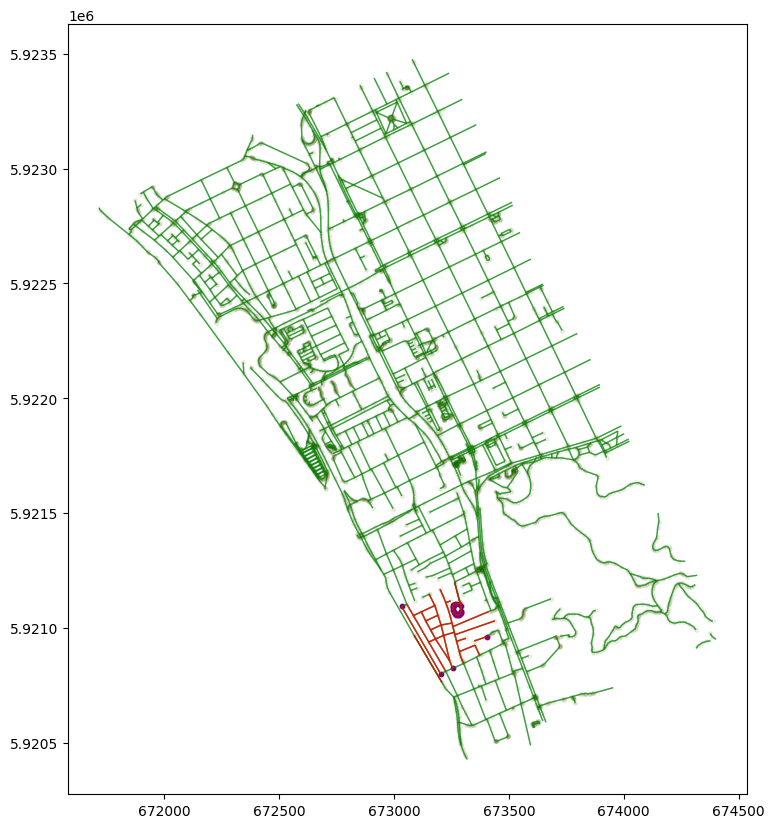

In [65]:
def get_df(dataset, time='actual', var='nodes'):
    return dataset[time][var]
def get_df_plate(dataset, time='actual', var='nodes', plate_id='1'):
    df = get_df(dataset, time, var)
    return df[df['plate_id']==plate_id]

plate_id = 7

nodes_res = pd.concat([
    dataset['actual']['nodes'].loc[dataset['actual']['nodes']['plate_id']!=plate_id],
    dataset['future']['nodes'].loc[dataset['future']['nodes']['plate_id']==plate_id],
    ]
)
edges_res = pd.concat([
    dataset['actual']['edges'].loc[dataset['actual']['edges']['plate_id']!=plate_id],
    dataset['future']['edges'].loc[dataset['future']['edges']['plate_id']==plate_id],
    ]
)

original_nodes = nodes_res.copy()

edges_plate = get_df_plate(dataset, plate_id=plate_id, var='edges', time='future')

def calc_nodes_to_fix(nodes_res, edges_plate):
    nodes_in_edges = pd.concat([
        edges_plate[['from']].rename(columns={'from':'osmid'}),
        edges_plate[['to']].rename(columns={'to':'osmid'}),
        ])
    current_nodes_set = nodes_res.copy()
    current_nodes_set['osmid'] = current_nodes_set['osmid'].astype(int)
    nodes_to_fix = nodes_in_edges[~nodes_in_edges['osmid'].isin(current_nodes_set['osmid'])]
    nodes_to_fix.drop_duplicates(inplace=True)
    nodes_to_fix = pd.merge(nodes_to_fix, get_df(dataset, time='future'), on='osmid')
    nodes_to_fix = gpd.GeoDataFrame(data=nodes_to_fix.drop(columns='geometry'), geometry=nodes_to_fix['geometry'])
    return nodes_to_fix

plate_id = 7

nodes_to_fix = calc_nodes_to_fix(nodes_res, edges_plate)

fig,ax = plt.subplots(figsize=(10,10))
edges_res.plot(ax=ax, color='green', linewidth=1, alpha=0.5)
nodes_res.plot(ax=ax, markersize=5, color='yellow', edgecolor='black', alpha=0.1)
nodes_to_fix.plot(ax=ax, color='purple', markersize=10)
edges_res[edges_res['plate_id']==plate_id].plot(ax=ax, linewidth=1, alpha=0.5,color='red')

Falló


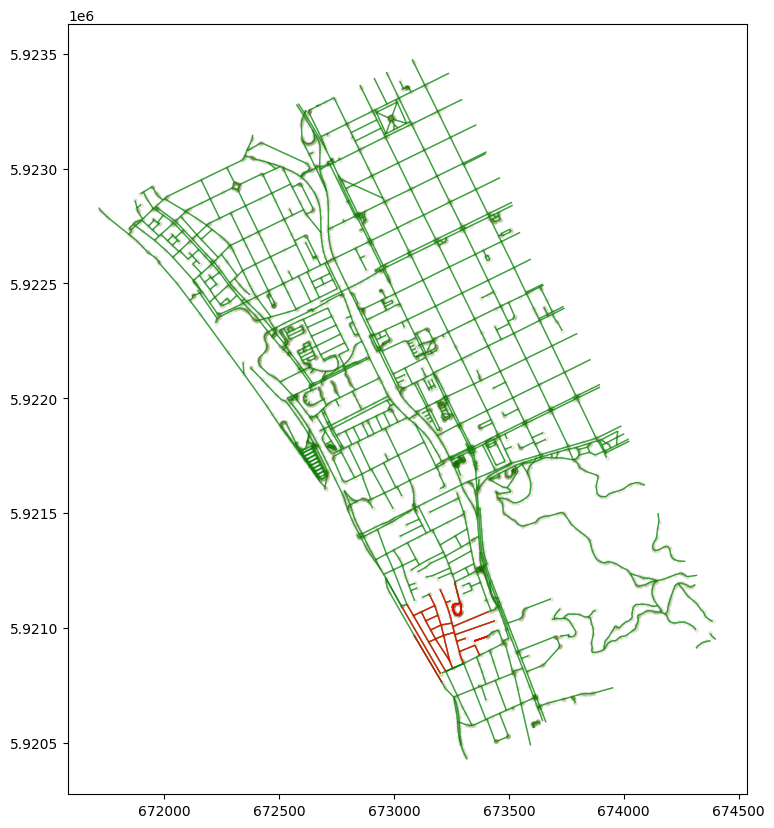

In [73]:
fig,ax = plt.subplots(figsize=(10,10))
edges_res.plot(ax=ax, color='green', linewidth=1, alpha=0.5)
nodes_res.plot(ax=ax, markersize=5, color='yellow', edgecolor='black', alpha=0.1)
nodes_to_fix.plot(ax=ax, color='purple', markersize=10)
edges_res[edges_res['plate_id']==plate_id].plot(ax=ax, linewidth=1, alpha=0.5, color='red')

test_net(nodes_res, edges_res)
nodes_to_fix = calc_nodes_to_fix(nodes_res, edges_plate)

#### %%%% ####
future_edges = get_df(dataset, time='future', var='edges')
actual_nodes = get_df(dataset, time='actual', var='nodes')

nodes_ids = nodes_to_fix['osmid']
mask = (future_edges['from'].isin(nodes_ids))#|(future_edges['to'].isin(nodes_ids))
future_edges_to_fix = future_edges[mask]
mask = future_edges_to_fix['to'].isin(actual_nodes['osmid'])
future_edges_to_fix = future_edges_to_fix[mask]
future_edges_to_fix = pd.concat([future_edges_to_fix, future_edges_to_fix.rename(columns={'u':'v', 'v':'u', 'to':'from', 'from': 'to'})])

# display(nodes_to_fix)
# display(future_edges_to_fix)

edges_plate = pd.concat([edges_plate, future_edges_to_fix])
nodes_res = pd.concat([nodes_res, nodes_to_fix])
edges_res = pd.concat([edges_res, future_edges_to_fix])

Falló


,osmid,y,x,street_cou,highway,plate_id,geometry


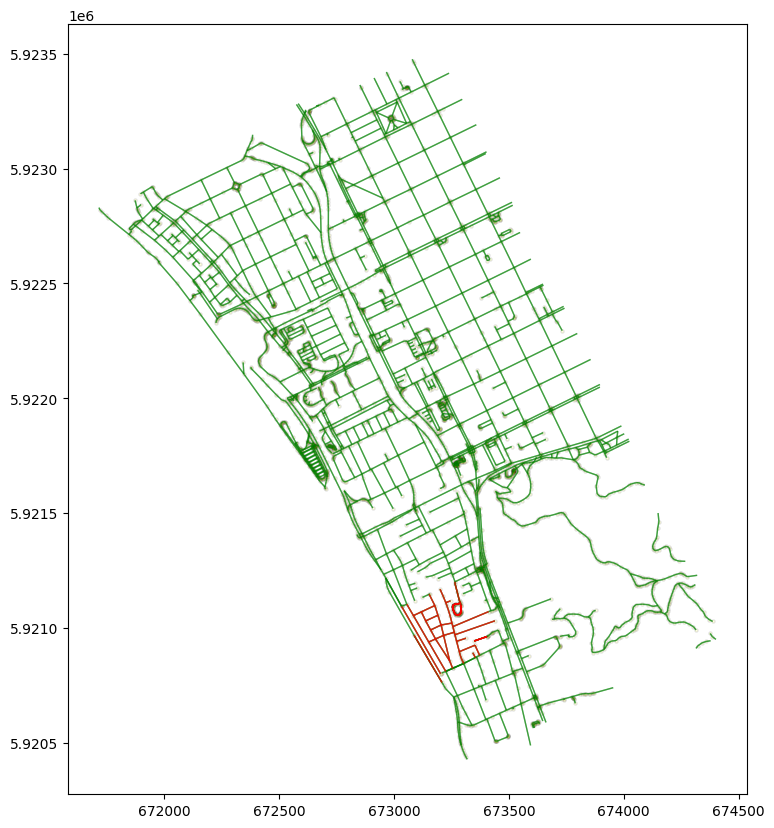

In [98]:
fig,ax = plt.subplots(figsize=(10,10))
edges_res.plot(ax=ax, color='green', linewidth=1, alpha=0.5)
nodes_res.plot(ax=ax, markersize=5, color='yellow', edgecolor='black', alpha=0.1)
nodes_to_fix.plot(ax=ax, color='purple', markersize=10)
edges_res[edges_res['plate_id']==plate_id].plot(ax=ax, linewidth=1, alpha=0.5, color='red')

test_net(nodes_res, edges_res)
# nodes_to_fix = calc_nodes_to_fix(nodes_res, edges_res)
nodes_in_edges = pd.concat([
        edges_res[['from']].rename(columns={'from':'osmid'}),
        edges_res[['to']].rename(columns={'to':'osmid'}),
])
current_nodes_set = nodes_res.copy()
current_nodes_set['osmid'] = current_nodes_set['osmid'].astype(int)
nodes_to_fix = nodes_in_edges[~nodes_in_edges['osmid'].isin(current_nodes_set['osmid'])]
nodes_to_fix.drop_duplicates(inplace=True)
nodes_to_fix = pd.merge(nodes_to_fix, get_df(dataset, time='actual'), on='osmid')
nodes_to_fix = gpd.GeoDataFrame(data=nodes_to_fix.drop(columns='geometry'), geometry=nodes_to_fix['geometry'])

nodes_to_fix
# display(edges_res)
# #### %%%% ####
actual_edges = get_df(dataset, time='actual', var='edges')
actual_nodes = get_df(dataset, time='actual', var='nodes')

nodes_ids = nodes_to_fix['osmid']
mask = (actual_edges['from'].isin(nodes_ids))#|(actual_edges['to'].isin(nodes_ids))
actual_edges_to_fix = actual_edges[mask]
mask = actual_edges_to_fix['to'].isin(actual_nodes['osmid'])
actual_edges_to_fix = actual_edges_to_fix[mask]
actual_edges_to_fix = pd.concat([actual_edges_to_fix, actual_edges_to_fix.rename(columns={'u':'v', 'v':'u', 'to':'from', 'from': 'to'})])

display(nodes_to_fix)


edges_plate = pd.concat([edges_plate, future_edges_to_fix])
nodes_res = pd.concat([nodes_res, nodes_to_fix])
edges_res = pd.concat([edges_res, future_edges_to_fix])

,osmid,x,y,plate_id,geometry


,u,v,key,from,to,osmid,plate_id,geometry,length


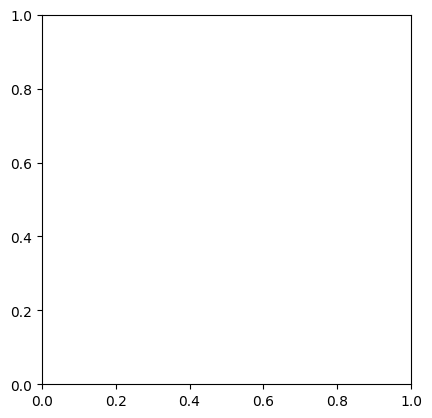

In [58]:
nodes_to_fix = calc_nodes_to_fix(nodes_res, edges_plate)

future_edges = get_df(dataset, time='future', var='edges')
actual_nodes = get_df(dataset, time='actual', var='nodes')

nodes_ids = nodes_to_fix['osmid']
mask = (future_edges['from'].isin(nodes_ids))#|(future_edges['to'].isin(nodes_ids))
future_edges_to_fix = future_edges[mask]
mask = future_edges_to_fix['to'].isin(actual_nodes['osmid'])
future_edges_to_fix = future_edges_to_fix[mask]
future_edges_to_fix = pd.concat([future_edges_to_fix, future_edges_to_fix.rename(columns={'u':'v', 'v':'u', 'to':'from', 'from': 'to'})])

future_edges_to_fix.plot()
display(nodes_to_fix)
display(future_edges_to_fix)

: 

In [213]:
#### %%%% ####
df_x = get_df(dataset, time='future', var='edges')
df_y = get_df(dataset)

nodes_ids = nodes_to_fix['osmid']
mask = (df_x['from'].isin(nodes_ids))#|(df_x['to'].isin(nodes_ids))
df_x = df_x[mask]
mask = df_x['to'].isin(df_y['osmid'])
df_x[mask]

,u,v,key,from,to,osmid,geometry,length,plate_id
40445,202436752,10687417530,0,202436752,10687417530,1148717221,"LINESTRING (673032.820 5921092.980, 672963.618...",142.115033,6.0
79502,202436750,5463500809,0,202436750,5463500809,96116239,"LINESTRING (673152.674 5921146.271, 673156.322...",4.049756,0.0
81445,202436750,1285932737,0,202436750,1285932737,96116239,"LINESTRING (673152.674 5921146.271, 673123.261...",32.469754,0.0
81446,202436893,1148149653,0,202436893,1148149653,2024071220232,"LINESTRING (673224.877 5920810.239, 673254.854...",32.797340,0.0
81448,202436893,1285931550,0,202436893,1285931550,2024071220233,"LINESTRING (673254.854 5920823.545, 673302.911...",52.529951,0.0


In [216]:
nodes_res[nodes_res['osmid'].isin(df_x['u'])]

,osmid,y,x,street_cou,highway,geometry,plate_id


In [202]:
edges_res = pd.concat([edges_res, df_x])

<Axes: >

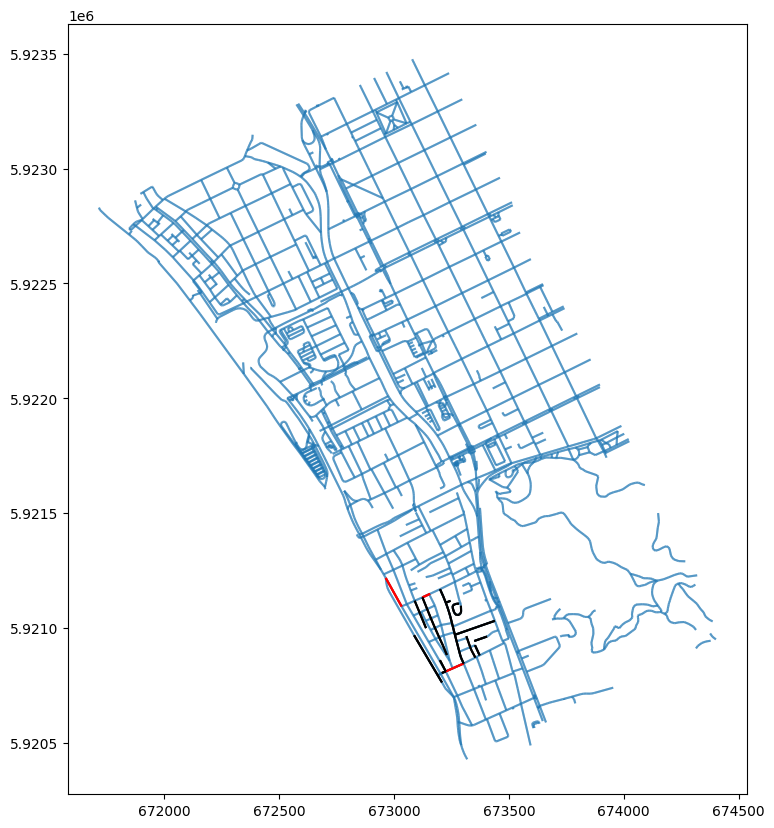

In [212]:
plate_id = 7
df = get_df_plate(dataset, time='actual', var='edges', plate_id=plate_id)
fig,ax = plt.subplots(figsize=(10,10))
edges_res.plot(ax=ax, alpha=0.5)
df_x.plot(ax=ax, color='red')
df.plot(ax=ax, color='black')

In [209]:
test_net(nodes_res, edges_res)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

,u,v,key,from,to,osmid,length,geometry,plate_id
37,303482194,1307330025,0,303482194,1307330025,116428623,28.261138,"LINESTRING (673352.983 5921720.676, 673348.277...",0.0
38,303482194,313193822,0,303482194,313193822,116428623,34.539595,"LINESTRING (673352.983 5921720.676, 673355.494...",0.0
106,309887717,9671098169,0,309887717,9671098169,928496869,46.089901,"LINESTRING (673823.937 5921808.822, 673868.203...",0.0
107,309887717,310072953,0,309887717,310072953,928496869,67.603844,"LINESTRING (673823.937 5921808.822, 673759.035...",0.0
108,309887718,313193822,0,309887718,313193822,981157257,69.747119,"LINESTRING (673359.796 5921616.614, 673357.680...",0.0
...,...,...,...,...,...,...,...,...,...
81445,202436750,1285932737,0,202436750,1285932737,96116239,36.511272,"LINESTRING (673152.674 5921146.271, 673123.261...",0.0
81446,202436893,1148149653,0,202436893,1148149653,2024071220232,NaN,"LINESTRING (673224.877 5920810.239, 673254.854...",0.0
81447,1148149653,202436893,0,1148149653,202436893,2024071220231,NaN,"LINESTRING (673224.877 5920810.239, 673254.854...",0.0
81448,202436893,1285931550,0,202436893,1285931550,2024071220233,NaN,"LINESTRING (673254.854 5920823.545, 673302.911...",0.0


,osmid,x,y,geometry,plate_id


,u,v,key,from,to,osmid,length,geometry,plate_id


Falló


,osmid,x,y,geometry,plate_id


,u,v,key,from,to,osmid,length,geometry,plate_id


Falló


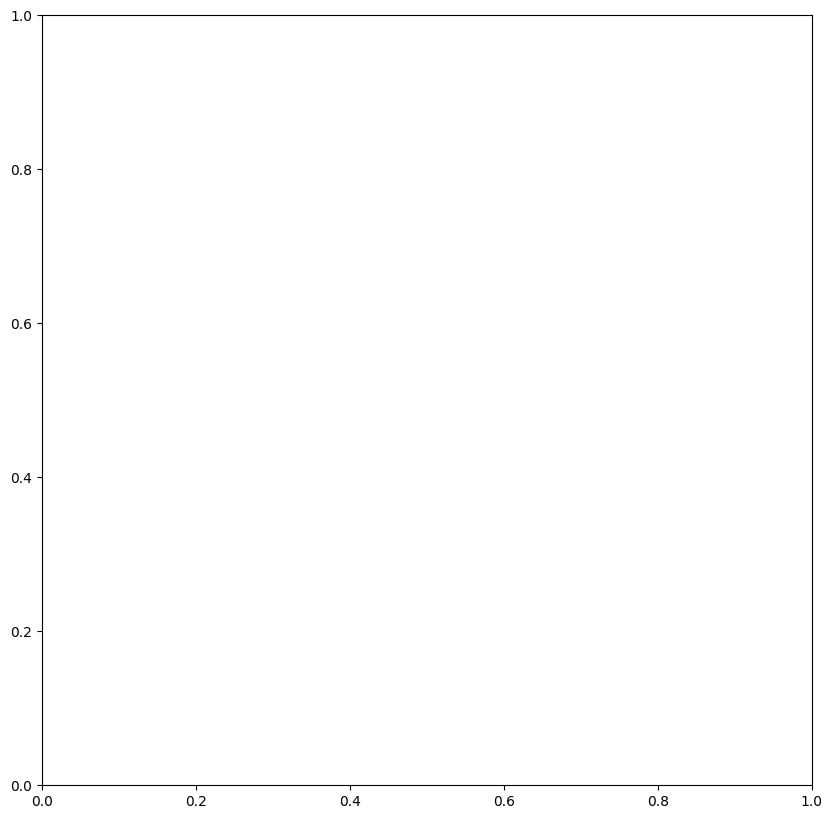

In [168]:
plate_id = 7
fig,ax = plt.subplots(figsize=(10,10))

#### %%%% ####
df = get_df(dataset, time='future', var='edges')


scenario, name = 'future', 'nodes'
cr = dataset[scenario][name]
nodes_to_add = cr[cr['osmid'].isin(nodes_to_fix)]
nodes_res = pd.concat([
    nodes_res,
    nodes_to_add
])
nodes_res.drop_duplicates(inplace=True)

#### PLOT ####
nodes_to_add.plot(color='red', ax=ax, markersize=5)
display(nodes_to_add)

scenario, name = 'future', 'edges'
st = dataset[scenario][name]
st = st[(st['from'].isin(nodes_to_add['osmid']))|(st['to'].isin(nodes_to_add['osmid']))]
# scenario, name = 'actual', 'nodes'
# nd = dataset[scenario][name]
# st = st[((st['from'].isin(nd['osmid']))|(st['to'].isin(nd['osmid'])))]
st = st[st['plate_id']!=plate_id]
edges_to_add = st.copy()
edges_res = pd.concat([
    edges_res,
    edges_to_add
])
edges_res.drop_duplicates(inplace=True)

#### PLOT ####
display(edges_to_add)
edges_to_add.plot(color='red', ax=ax, markersize=5)

test_net(nodes_res, edges_res)

scenario, name = 'future', 'nodes'
cr = dataset[scenario][name]
cr = cr[((cr['osmid'].isin(st['from']))|(cr['osmid'].isin(st['to'])))]
cr = cr[~cr['osmid'].isin(nodes_res['osmid'])]
nodes_to_add = cr.copy()
nodes_res = pd.concat([
    nodes_res,
    nodes_to_add
])
nodes_res.drop_duplicates(inplace=True)

#### PLOT ####
display(nodes_to_add)
nodes_to_add.plot(color='red', ax=ax, markersize=5)

scenario, name = 'actual', 'edges'
st = dataset[scenario][name]
st = st[(st['from'].isin(nodes_to_add['osmid']))|(st['to'].isin(nodes_to_add['osmid']))]
st = st[st['plate_id']!=plate_id]
edges_to_add = st.copy()
edges_res = pd.concat([
    edges_res,
    edges_to_add
])
edges_res.drop_duplicates(inplace=True)

#### PLOT ####
edges_to_add.plot(color='red', ax=ax, markersize=5)
display(edges_to_add)

try:
    nodes, edges = _current_nodes_edges_to_net_format(nodes_res, edges_res)
    net = _make_network(nodes, edges)
except:
    print('Falló')

In [208]:
def test_net(node_res, edges_res):
    # try:
    nodes, edges = _current_nodes_edges_to_net_format(nodes_res, edges_res)
    net = _make_network(nodes, edges)
    # except:
    #     print('Falló')

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

<Axes: >

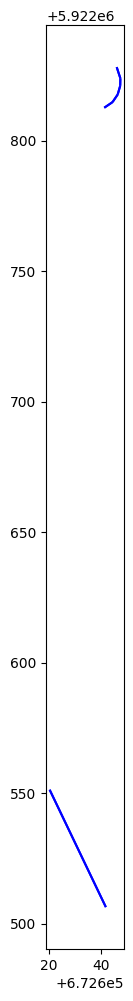

In [112]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
# gpd.sjoin(missing_nodes, area).plot(ax=ax, color='red', markersize=5)
gpd.sjoin(missing_edges, area).plot(ax=ax, color='blue',markersize=5)
# plates.plot(ax=ax, alpha=0.4)

In [80]:
nodes_df, edges_df = _current_nodes_edges_to_net_format(net_nodes, net_edges)
net = _make_network(nodes_df, edges_df)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'